In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
import scipy.io
import time
#from progress.bar import Bar

sns.set()
sns.set_style("white")

%matplotlib inline


## Simulation module implementation

### Description of the simulation module

At a high level, the simulation alternates between two states which is encoded by a variable `s`. In the setup, `u` and `v` are two neurons that mutually inhibit each other according to this dynamics:

$$ \tau\frac{du}{dt} = -u + \theta \ (W_{uI}I - W_{uv}v - sI_F)$$

Similarly for $v$,

$$ \tau\frac{dv}{dt} = -v + \theta \ (W_{vI}I - W_{vu}u + sI_F)$$

$y$ and $z$ are read-out neurons. $y$ measures the difference between $u$ and $v$ and $z$ measures the deviation of $y$ from the threshold $y_0$.

$$ \tau\frac{dy}{dt} = -y + u - v $$

The global state is given by $s$ which is an external signal. This state alternates between two modes:

* When $s = 0$, the network operates in *integration* mode
    - $v$ receives an impulse $I_p = 50$, for a duration of one time steps. After that $I_p = 0$.
    - $I$ remains constant (gated out, uncoupled from $y$)


* When $s = 1$, the network operates in *update* mode
    - $I_p$ continues to be 0.
    - $I$ gets coupled to $y$.
    
    
In particular, $ \tau\frac{dI}{dt} = sK(y-y_0)  $

In [2]:
PARAMS_DICT = {'Wut': 6,
              'Wuv': 6,
              'Wvt': 6,
              'Wvu': 6,
              'dt': 10,
              'tau': 100,
              'ext': 0,
              'y0': 0.7,
              'IF': 100,
              'uinit': 0.7,
              'vinit': 0.2,
              'yinit': 0.5}

In [3]:
def thresh_exp(x):
    '''Sigmoid non-linearity'''
    return 1 / (1 + np.exp(-x))

def start_simulation_parallel(state_init, params, K, sigma, niter):
    '''
    Inputs:
    state_init: an array which includes:
        * I: initial current
        * u: initial state of u
        * v: initial state of v
        * y: initial state of y (readout neuron)
        * sig: state indicator (0 or 1)
        
    params: a dictionary of relevant parameters
    niter: number of iterations
    
    Outputs: each list contains niter elements
    u_lst: list of u activities 
    v_lst: list of v activities
    y_lst: list of y activities
    I_lst: list of I activities
    sig_lst: list of sig in this simulation
        
    '''
    
    # Unpack parameters of the simulation
    Wut = params['Wut']
    Wuv = params['Wuv']
    Wvt = params['Wvt']
    Wvu = params['Wvu']
    dt = params['dt']
    tau = params['tau']
    ext = params['ext']
    y0 = params['y0'] #The target (threshold) value of y
    IF = params['IF']
    
    # Unpack variables
    I, u, v, y, sig = state_init
    
    ntrials = len(I)
    
    I = I.copy()
    u = u.copy()
    v = v.copy()
    y = y.copy()
        
    sig_lst = []
    u_lst = []
    v_lst = []
    y_lst = []
    I_lst = []
    
    for i in range(niter):                
        # Update I, u, v and y
        I += (sig * K * (y - y0)) / tau * dt
        u += (-u + thresh_exp(Wut * I - Wuv * v - sig * IF + np.random.randn(ntrials) * sigma)) / tau * dt
        v += (-v + thresh_exp(Wvt * I - Wvu * u + sig * IF + np.random.randn(ntrials) * sigma)) / tau * dt
        y += (-y + u - v + np.random.randn(ntrials) * sigma) / tau * dt

        v_lst.append(v.copy())
        u_lst.append(u.copy())
        y_lst.append(y.copy())
        I_lst.append(I.copy())
        sig_lst.append(sig)    
        
    return u_lst, v_lst, y_lst, I_lst, sig_lst

In [4]:
def plot_simulation_parallel(ulst, vlst, ylst, Ilst, siglst, params_dict):
    '''Plot the simulations'''
    dt = params_dict['dt']
    nsteps = len(ulst)
    tlst = np.arange(nsteps).astype('int')
    sig_lst = np.floor(tlst / 100) % 2
    sig_lst = sig_lst.astype('int')
    
    ulst_arr = np.array(ulst)
    vlst_arr = np.array(vlst)
    ylst_arr = np.array(ylst)
    Ilst_arr = np.array(Ilst)
    
    wherelst = np.array(siglst) == 1.0
    wherelst_shifted = np.concatenate((wherelst[1:], [False]))
    wherelst += wherelst_shifted
    
    #wherelst2 = np.array(siglst) == 2.0

    fig, ax = plt.subplots(4, 1, figsize=(10, 10))
    ax[0].plot(np.arange(nsteps) * dt, ulst_arr, 'b', alpha=0.2)
    ax[0].set_ylabel('u')
    ax[0].fill_between(np.arange(nsteps) * dt, np.min(np.array(ulst)), np.max(np.array(ulst)), where=wherelst, alpha=0.5)
    #ax[0].fill_between(np.arange(nsteps) * dt, np.min(np.array(ulst)), np.max(np.array(ulst)), where=wherelst2, alpha=0.2)

    ax[1].plot(np.arange(nsteps) * dt, vlst_arr, 'b', alpha=0.2)
    ax[1].set_ylabel('v')
    ax[1].fill_between(np.arange(nsteps) * dt, np.min(np.array(vlst)), np.max(np.array(vlst)), where=wherelst, alpha=0.5)
    #ax[1].fill_between(np.arange(nsteps) * dt, np.min(np.array(vlst)), np.max(np.array(vlst)), where=wherelst2, alpha=0.2)

    ax[2].plot(np.arange(nsteps) * dt, ylst_arr, 'b', alpha=0.2)
    ax[2].set_ylabel('y')
    ax[2].fill_between(np.arange(nsteps) * dt, np.min(np.array(ylst)), np.max(np.array(ylst)), where=wherelst, alpha=0.5)
    #ax[2].fill_between(np.arange(nsteps) * dt, np.min(np.array(ylst)), np.max(np.array(ylst)), where=wherelst2, alpha=0.2)
    ax[2].hlines(PARAMS_DICT['y0'], 0, nsteps * dt, linestyle='dotted')

    ax[3].plot(np.arange(nsteps) * dt, Ilst_arr, 'b', alpha=0.2)
    ax[3].set_ylabel('I')
    ax[3].fill_between(np.arange(nsteps) * dt, np.min(np.array(Ilst)), np.max(np.array(Ilst)), where=wherelst, alpha=0.5)
    #ax[3].fill_between(np.arange(nsteps) * dt, np.min(np.array(Ilst)), np.max(np.array(Ilst)), where=wherelst2, alpha=0.2)
    ax[3].set_xlabel('Time (ms)');

In [5]:
# Functions for using in a for loop
def get_times_lst_from_y(ylst):
    '''
    Input:
    - ylst: np array of y activations
    
    Output:
    A 1d array of the times to threshold of the last behavior
    '''
    
    ndiscard = 10
    threshold = PARAMS_DICT['y0']
    # Discard first 10 samples
    ylst = ylst[ndiscard:]
    times_lst = []
    ntrials = ylst.shape[1]
    
    # Find time to act
    for k in range(ntrials):
        # Check if the bound is reached (sometimes it's not!)
        if np.max(ylst[:,k]) > threshold:
            times_lst.append(np.nonzero(ylst[:, k] > threshold)[0][0])
        else:
            times_lst.append(np.inf)
            #print('Bound not reached')
    
    return np.array(times_lst) + ndiscard

def simulate_trial(ntrials=1000, duration=600, nstages=10, sigma=0, K=3.0, initI=0.7):
    # Initial run
    #ntrials = 1000
    #duration = 600 #ms
    #nstages = 10
    PARAMS_DICT['sigma'] = sigma
    PARAMS_DICT['K'] = K
    first_duration = 750 #duration in ms of first duration (500 ms + exponential with mean 250)
    
    nbin = int(duration / PARAMS_DICT['dt'])
    nbinfirst = int(first_duration / PARAMS_DICT['dt'])
    
    uinit = PARAMS_DICT['uinit']
    vinit = PARAMS_DICT['vinit']
    yinit = PARAMS_DICT['yinit']

    state_init = [np.ones(ntrials) * initI, 
                  np.ones(ntrials) * uinit, 
                  np.ones(ntrials) * vinit,
                  np.ones(ntrials) * yinit,
                  0.0]

    ulst, vlst, ylst, Ilst, siglst = start_simulation_parallel(state_init, PARAMS_DICT, 0, sigma, nbinfirst)

    # For subsequent runs, flip the state every 100 trials
    for k in range((nstages - 2) * 2):
        #acoefs = 1 - acoefs
        state_init = [Ilst[-1], ulst[-1], vlst[-1], ylst[-1], (state_init[4] + 1.0)%2]
        if state_init[4] == 0.0:
            ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, K, sigma, nbin)
        else:
            if k == 0:
                # No update for first flash
                ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, 0, sigma, 1)
            else:
                ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, K, sigma, 1)

        ulst += ulst2
        vlst += vlst2
        ylst += ylst2
        Ilst += Ilst2
        siglst += siglst2

    if nstages > 1:
        state_init = [Ilst[-1], ulst[-1], vlst[-1], ylst[-1], (state_init[4] + 1.0)%2]
        # For the last run, produce the behavior when the threshold is reached
        ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, K, sigma, 1)

        ulst += ulst2
        vlst += vlst2
        ylst += ylst2
        Ilst += Ilst2
        siglst += siglst2
        
        state_init = [Ilst[-1], ulst[-1], vlst[-1], ylst[-1], (state_init[4] + 1.0)%2]
        # For the last run, produce the behavior when the threshold is reached
        ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, K, sigma, nbin * 2)

        ulst += ulst2
        vlst += vlst2
        ylst += ylst2
        Ilst += Ilst2
        
        siglst2[nbin] = 1
        siglst += siglst2
    else:
        print(len(siglst))
        siglst[-1] = 1
        ylst2 = ylst

    return ulst, vlst, ylst, Ilst, siglst, ylst2


def get_time_lst(ntrials=1000, duration=600, nstages=10, sigma=0, K=3.0, initI=0.7):
    '''Simulate and return the array of times of threshold crossing'''
    _, _, _, _, _, ylst2 = simulate_trial(ntrials=ntrials, nstages=nstages, duration=duration, 
                                                                       sigma=sigma, K=K, initI=initI)
    Ylst2 = np.array(ylst2)
    times = get_times_lst_from_y(np.array(Ylst2))
    times = times[(times > 0) & (times != np.inf)]
    return times

In [57]:
times

array([194., 157., 118., 179., 191., 155.])

Mean decision time is  165.66666666666666


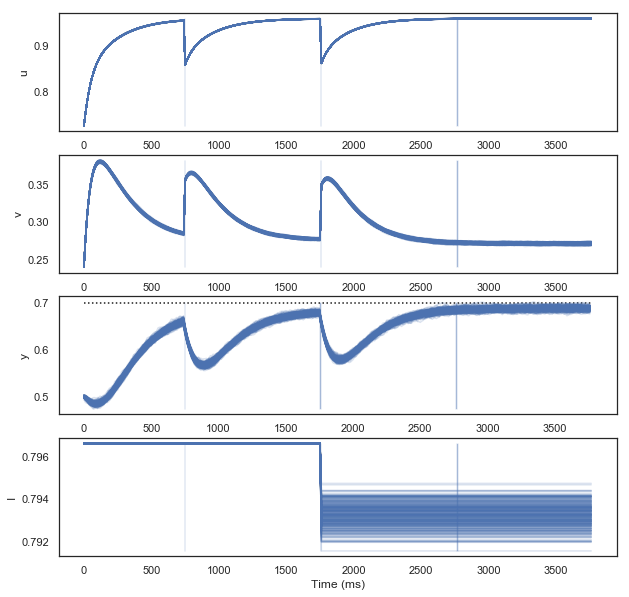

In [56]:
sigma = 0.0166
I = 0.7966163348999331
K = 1.5836092260535015
duration = 1000

#ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(nstages=3, sigma=sigma, K=K, initI=0.766)
np.random.seed(2018)
ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=300, nstages=3, duration=duration, sigma=sigma, 
                                                       K=K, initI=I)
plot_simulation_parallel(ulst, vlst, ylst, Ilst, siglst, PARAMS_DICT)

Ylst2 = np.array(ylst2)
times = get_times_lst_from_y(np.array(Ylst2))
times = times[(times > 0) & (times != np.inf)]
print('Mean decision time is ', np.mean(times))

# Save the parameters in a .mat file
#scipy.io.savemat('PlotTools/uv_simulation_data012619_K3_164_I0_7825_s0_0136_1000ms.mat', {'ulst': ulst, 'vlst': vlst, 'ylst': ylst, 
#                                                  'Ilst': Ilst, 'siglst': siglst, 'PARAMS': PARAMS_DICT,
#                                                   'sigma': sigma, 'K': K, 'I': I})

## Optimizing over a single ISI

In [ ]:
#TODO: function to find I that hits the correct interval in 1 iteration..(?)

In [8]:
np.random.seed(123)
Klst = np.linspace(0, 4, 20)
sigma_lst = np.linspace(0.01, 0.1, 6)

meanlst = np.zeros((len(sigma_lst), len(Klst)))
varlst = np.zeros((len(sigma_lst), len(Klst)))

duration = 600

for i in range(len(sigma_lst)):
    for j in range(len(Klst)):
        sigma = sigma_lst[i]
        K = Klst[j]
        print('Working on K = ', K)
        ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=20000, nstages=3, 
                                                               duration=duration, sigma=sigma, K=K, initI=0.84)
        times = get_times_lst_from_y(np.array(ylst2))
        times_filt = times[(times > 0) & (times != np.inf)]
        
        if len(times_filt) < len(times):
            print('inf encountered')
            meanlst[i][j] = np.NAN
            varlst[i][j] = np.NAN
        else:
            meanlst[i][j] = np.mean(times)
            varlst[i][j] = np.std(times)

Working on K =  0.0
Working on K =  0.21052631578947367
Working on K =  0.42105263157894735
Working on K =  0.631578947368421
Working on K =  0.8421052631578947
Working on K =  1.0526315789473684
Working on K =  1.263157894736842
Working on K =  1.4736842105263157
Working on K =  1.6842105263157894
Working on K =  1.894736842105263
Working on K =  2.1052631578947367
Working on K =  2.3157894736842106
Working on K =  2.526315789473684
Working on K =  2.7368421052631575
Working on K =  2.9473684210526314
Working on K =  3.1578947368421053
Working on K =  3.3684210526315788
Working on K =  3.578947368421052
Working on K =  3.789473684210526
Working on K =  4.0
Working on K =  0.0
Working on K =  0.21052631578947367
Working on K =  0.42105263157894735
Working on K =  0.631578947368421
Working on K =  0.8421052631578947
Working on K =  1.0526315789473684
Working on K =  1.263157894736842
Working on K =  1.4736842105263157
Working on K =  1.6842105263157894
Working on K =  1.894736842105263


Text(0, 0.5, '$\\sigma$')

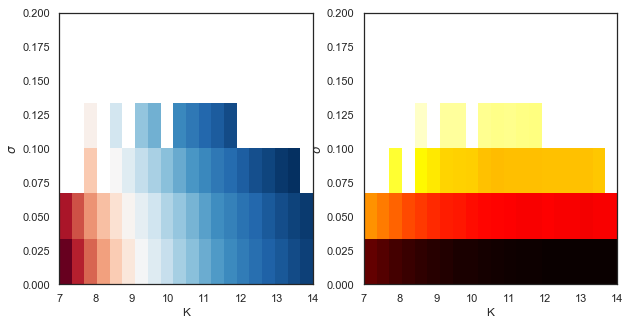

In [9]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.flipud((meanlst - 60)), cmap='RdBu_r', extent=[7, 14, 0, 0.2], aspect='auto')
plt.xlabel('K')
plt.ylabel(r'$\sigma$')

plt.subplot(1, 2, 2)
plt.imshow(np.flipud(varlst), extent=[7, 14, 0, 0.2], cmap='hot', aspect='auto')
plt.xlabel('K')
plt.ylabel(r'$\sigma$')

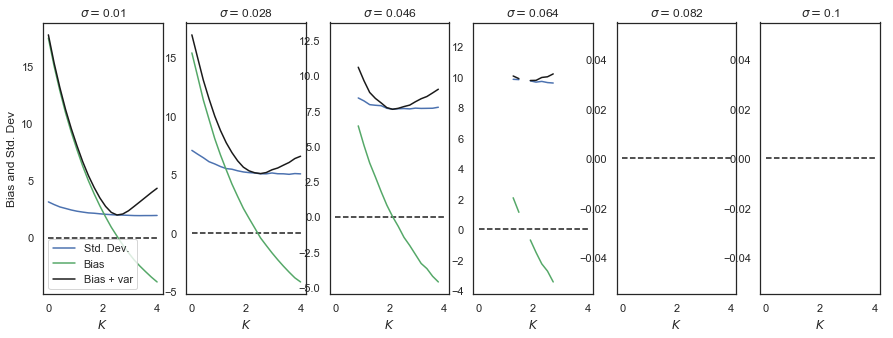

In [10]:
rmselst = np.sqrt((meanlst - 60) ** 2 + varlst**2)

fig, ax = plt.subplots(1, 6, figsize=(15, 5))
for i in range(6):
    sq_bias = (meanlst[i]-400)**2
    biasid = np.argmin(sq_bias)
    varid = np.argmin(varlst[i])
    ax[i].plot(Klst, varlst[i], color='b', label='Std. Dev.')
    ax[i].plot(Klst, meanlst[i] - 60, color='g', label='Bias')
    ax[i].plot(Klst, rmselst[i], color='k', label='Bias + var')
    #ax[i].set_ylim((-5, 10))
    ax[i].set_xlabel(r'$K$')
    ax[i].set_title(r'$\sigma=$' + str(np.round(sigma_lst[i], 3)))
    ax[i].hlines(0, min(Klst), max(Klst), linestyles='--')
    #ax[i-1].axvline(x=Klst[biasid], linestyle='--', color='g')
    #ax[i-1].axvline(x=Klst[varid], linestyle='--', color='b')

ax[0].set_ylabel('Bias and Std. Dev')
ax[0].legend(loc='lower left');
#save_safe('bias_variance_sigma_sigma.pdf')

C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


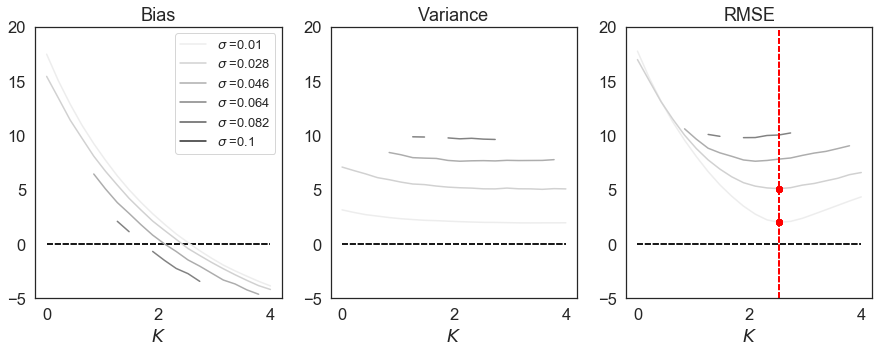

In [11]:
sns.set(font_scale=1.5)
sns.set_style('white')

colorsR = sns.color_palette('OrRd', 6)
colorsB = sns.color_palette('Blues', 6)
colorsG = sns.color_palette('Greys', 6)

rmsemins = np.min(rmselst, axis=1)
rmseargmins = np.argmin(rmselst, axis=1)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(6):
    sq_bias = (meanlst[i]-400)**2
    biasid = np.argmin(sq_bias)
    varid = np.argmin(varlst[i])
    #ax[0].plot(Klst, varlst[i], color='b', label='Std. Dev.')
    ax[0].plot(Klst, meanlst[i] - 60, color=colorsG[i], 
               label=r'$\sigma$ =' + str(np.round(sigma_lst[i], 3)))
    #ax[0].plot(Klst, np.sqrt((meanlst[i] - 60) ** 2 + varlst[i]**2), color='k')
    ax[0].set_ylim((-5, 20))
    ax[0].set_xlabel(r'$K$')
    ax[0].set_title('Bias')
    ax[0].hlines(0, min(Klst), max(Klst), linestyles='--')
    #ax[i-1].axvline(x=Klst[biasid], linestyle='--', color='g')
    #ax[i-1].axvline(x=Klst[varid], linestyle='--', color='b')
    
for i in range(6):
    sq_bias = (meanlst[i]-400)**2
    biasid = np.argmin(sq_bias)
    varid = np.argmin(varlst[i])
    ax[1].plot(Klst, varlst[i], color=colorsG[i])
    #ax[1].plot(Klst, meanlst[i] - 60, color='g', label='Bias')
    #x[1].plot(Klst, np.sqrt((meanlst[i] - 60) ** 2 + varlst[i]**2), color='k')
    ax[1].set_ylim((-5, 20))
    ax[1].set_xlabel(r'$K$')
    ax[1].set_title('Variance')
    ax[1].hlines(0, min(Klst), max(Klst), linestyles='--')
    #ax[i-1].axvline(x=Klst[biasid], linestyle='--', color='g')
    #ax[i-1].axvline(x=Klst[varid], linestyle='--', color='b')
    
for i in range(6):
    sq_bias = (meanlst[i]-400)**2
    biasid = np.argmin(sq_bias)
    varid = np.argmin(varlst[i])
    #ax[0].plot(Klst, varlst[i], color='b', label='Std. Dev.')
    #ax[0].plot(Klst, meanlst[i] - 60, color='g', label='Bias')
    ax[2].plot(Klst, rmselst[i], color=colorsG[i])
    ax[2].set_ylim((-5, 20))
    ax[2].set_xlabel(r'$K$')
    ax[2].set_title('RMSE')
    ax[2].hlines(0, min(Klst), max(Klst), linestyles='--')
    #ax[2].plot(Klst[rmseargmins], rmsemins, '--', color=[1,0,0])
    ax[2].plot(Klst[rmseargmins], rmsemins, 'o', color=[1,0,0])
    ax[2].axvline(x=Klst[rmseargmins[0]], linestyle='--', color=[1,0,0])
    #ax[i-1].axvline(x=Klst[varid], linestyle='--', color='b')

#ax[0].set_ylabel('Bias and Std. Dev')
ax[0].legend(loc='upper right',
               prop={'size': 13});
plt.savefig('bias_variance_rmse_by_sigma.pdf')

## Optimizing over a prior

### Ready, Set, Go task

Our prior will be a discrete uniform distribution 600, 700, ..., 1000 ms.

We simulate the 1-2-Go and 1-2-3-Go tasks below and calculate the MSE landscape. $(I, K)$ will be sampled from a grid of values.

In [30]:
# Trial duration is uniformly sampled from in [600, 1000]
durations = np.linspace(600, 1000, 5)

prod_time_lst = []
prod_var_lst = []

sigma_lst = np.linspace(0.005, 0.03, 6)

nK = 10
nI = 10
Klst = np.linspace(2, 3.5, nK)
initIlst = np.linspace(0.83, 0.86, nI)
MSELST = []

for id_s, sigma in enumerate(sigma_lst):
    print('*** sigma = ', sigma, ' ***')
    mse_lst = np.zeros((nI, nK))
    for i, I in enumerate(initIlst):
        for j, K in enumerate(Klst):
            #print('I = ', I, 'K = ', K)
            mse_total = 0
            for k, dur in enumerate(durations):
                #print('Doing time #', i, '=', time)

                ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=1000, nstages=3, 
                                                                       duration=dur, sigma=sigma, K=K, initI=I)

                Ylst2 = np.array(ylst2)
                times = get_times_lst_from_y(np.array(Ylst2))
                times = times[(times > 0) & (times != np.inf)]

                mse_total += np.sum((times * 10 - time)**2)

            mse_lst[i][j] = mse_total
            print('I = ', I, 'K = ', K, 'Total MSE = ', np.sqrt(np.mean(mse_total)))
    MSELST.append(mse_lst)
    

*** sigma =  0.005  ***
I =  0.83 K =  2.0 Total MSE =  13747.465220905271
I =  0.83 K =  2.1666666666666665 Total MSE =  13247.067600038885
I =  0.83 K =  2.3333333333333335 Total MSE =  12741.153793907364
I =  0.83 K =  2.5 Total MSE =  12228.691671638468
I =  0.83 K =  2.6666666666666665 Total MSE =  11720.878806642444
I =  0.83 K =  2.833333333333333 Total MSE =  11177.338681457228
I =  0.83 K =  3.0 Total MSE =  10682.017599685933
I =  0.83 K =  3.1666666666666665 Total MSE =  10132.285033495653
I =  0.83 K =  3.333333333333333 Total MSE =  9613.396902240123
I =  0.83 K =  3.5 Total MSE =  9026.173053958139
I =  0.8333333333333333 K =  2.0 Total MSE =  12095.015502263732
I =  0.8333333333333333 K =  2.1666666666666665 Total MSE =  11680.958864750788
I =  0.8333333333333333 K =  2.3333333333333335 Total MSE =  11266.35255972402
I =  0.8333333333333333 K =  2.5 Total MSE =  10886.872829237971
I =  0.8333333333333333 K =  2.6666666666666665 Total MSE =  10439.516272318368
I =  0.8333

I =  0.8366666666666667 K =  2.1666666666666665 Total MSE =  10355.457498343567
I =  0.8366666666666667 K =  2.3333333333333335 Total MSE =  10097.375896736736
I =  0.8366666666666667 K =  2.5 Total MSE =  9837.367534050967
I =  0.8366666666666667 K =  2.6666666666666665 Total MSE =  9538.652944729669
I =  0.8366666666666667 K =  2.833333333333333 Total MSE =  9137.237000319079
I =  0.8366666666666667 K =  3.0 Total MSE =  8884.835395211327
I =  0.8366666666666667 K =  3.1666666666666665 Total MSE =  8522.44683174967
I =  0.8366666666666667 K =  3.333333333333333 Total MSE =  8257.366408244217
I =  0.8366666666666667 K =  3.5 Total MSE =  7988.316468443148
I =  0.84 K =  2.0 Total MSE =  9090.434533068263
I =  0.84 K =  2.1666666666666665 Total MSE =  8983.779828112441
I =  0.84 K =  2.3333333333333335 Total MSE =  8750.337136362234
I =  0.84 K =  2.5 Total MSE =  8570.840098846787
I =  0.84 K =  2.6666666666666665 Total MSE =  8425.354591944484
I =  0.84 K =  2.833333333333333 Total M

I =  0.8433333333333333 K =  2.5 Total MSE =  8294.40172646587
I =  0.8433333333333333 K =  2.6666666666666665 Total MSE =  8118.65136583657
I =  0.8433333333333333 K =  2.833333333333333 Total MSE =  8123.0597683385295
I =  0.8433333333333333 K =  3.0 Total MSE =  7951.69793188851
I =  0.8433333333333333 K =  3.1666666666666665 Total MSE =  7804.178368028245
I =  0.8433333333333333 K =  3.333333333333333 Total MSE =  7724.35110543274
I =  0.8433333333333333 K =  3.5 Total MSE =  7605.031229390186
I =  0.8466666666666667 K =  2.0 Total MSE =  8242.469290206667
I =  0.8466666666666667 K =  2.1666666666666665 Total MSE =  8080.67447679957
I =  0.8466666666666667 K =  2.3333333333333335 Total MSE =  7872.909246269767
I =  0.8466666666666667 K =  2.5 Total MSE =  7702.356782180374
I =  0.8466666666666667 K =  2.6666666666666665 Total MSE =  7566.696769396802
I =  0.8466666666666667 K =  2.833333333333333 Total MSE =  7446.07950535045
I =  0.8466666666666667 K =  3.0 Total MSE =  7236.71886

I =  0.85 K =  2.6666666666666665 Total MSE =  8123.786063160453
I =  0.85 K =  2.833333333333333 Total MSE =  8091.853928488823
I =  0.85 K =  3.0 Total MSE =  7881.992133972223
I =  0.85 K =  3.1666666666666665 Total MSE =  8013.800596471066
I =  0.85 K =  3.333333333333333 Total MSE =  7949.521998208445
I =  0.85 K =  3.5 Total MSE =  7904.6189028946865
I =  0.8533333333333333 K =  2.0 Total MSE =  11161.482876392365
I =  0.8533333333333333 K =  2.1666666666666665 Total MSE =  10204.293214132962
I =  0.8533333333333333 K =  2.3333333333333335 Total MSE =  9421.735508917664
I =  0.8533333333333333 K =  2.5 Total MSE =  8766.019621242014
I =  0.8533333333333333 K =  2.6666666666666665 Total MSE =  8407.068454580349
I =  0.8533333333333333 K =  2.833333333333333 Total MSE =  8208.501690320834
I =  0.8533333333333333 K =  3.0 Total MSE =  7951.572171589716
I =  0.8533333333333333 K =  3.1666666666666665 Total MSE =  7736.34926822723
I =  0.8533333333333333 K =  3.333333333333333 Total M

I =  0.8566666666666667 K =  2.833333333333333 Total MSE =  9324.355205589285
I =  0.8566666666666667 K =  3.0 Total MSE =  9110.0
I =  0.8566666666666667 K =  3.1666666666666665 Total MSE =  8673.148217342996
I =  0.8566666666666667 K =  3.333333333333333 Total MSE =  8608.925600793633
I =  0.8566666666666667 K =  3.5 Total MSE =  8683.357645519387
I =  0.86 K =  2.0 Total MSE =  16654.720051685046
I =  0.86 K =  2.1666666666666665 Total MSE =  14851.680039645347
I =  0.86 K =  2.3333333333333335 Total MSE =  13150.813663040017
I =  0.86 K =  2.5 Total MSE =  11848.096893594346
I =  0.86 K =  2.6666666666666665 Total MSE =  10394.233978509432
I =  0.86 K =  2.833333333333333 Total MSE =  9815.533607501937
I =  0.86 K =  3.0 Total MSE =  9287.911498286361
I =  0.86 K =  3.1666666666666665 Total MSE =  8848.06758563699
I =  0.86 K =  3.333333333333333 Total MSE =  8532.637341408576
I =  0.86 K =  3.5 Total MSE =  8568.774708206536
*** sigma =  0.03  ***
I =  0.83 K =  2.0 Total MSE =  1

In [153]:
scipy.io.savemat('PlotTools/IK_relationship_sigma_0-02_102918_1000trials.mat', {'MSELST': MSELST,
                                                          'Klst': Klst,
                                                          'Ilst': initIlst})

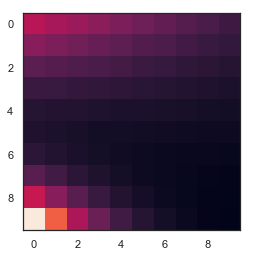

In [33]:
plt.imshow(MSELST[1])

Instead of sampling from a grid of $(I, K)$, here we do a random sampling of $(I, K)$.

In [64]:
def sampling_IK_optimization(sigma_lst, nstages, nsamples=100, maxiter=5):
    '''Perform optimization of (I, K), given parameters sigma'''
    durations = np.linspace(600, 1000, 5)
    ILST = np.zeros((len(sigma_lst), maxiter))
    KLST = np.zeros((len(sigma_lst), maxiter))

    # Do simulation several times to obtain error bars
    for id_s, sigma in enumerate(sigma_lst):
        print('*** sigma = ', sigma, ' ***')
        for niter in range(maxiter):
            print('    Running iteration #', niter)
            # For each iteration, re-pick list of I and K
            Klst = np.random.uniform(low=1, high=10, size=nsamples)
            initIlst = np.random.uniform(low=0.77, high=0.8, size=nsamples)

            mse_lst = np.zeros(nsamples)
            for i in range(nsamples):
                I = initIlst[i]
                K = Klst[i]
                mse_total = 0
                #print('        Doing time I = %f. K = %f' % (I, K))
                for k, dur in enumerate(durations):
                    #print('        Doing time #%d = %f. I = %f. K = %f\n' % (k, time, I, K))

                    ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=100, nstages=nstages, 
                                                                           duration=dur, sigma=sigma, K=K, initI=I)

                    Ylst2 = np.array(ylst2)
                    times = get_times_lst_from_y(np.array(Ylst2))
                    times = times[(times > 0) & (times != np.inf)]

                    if len(times) < 100:
                        mse_total = np.inf
                        #print('no time')
                        break
                    mse_total += np.sum((times * 10 - dur)**2)
                    #print('          times:', times)

                mse_lst[i] = np.sqrt(np.mean(mse_total))
                #print('I = ', I, 'K = ', K, 'Total MSE = ', np.sqrt(np.mean(mse_total)))
                #bar.next()
            # Determine the arg-min of the list
            argmin = np.argsort(mse_lst)
            Kmin = Klst[argmin[0]]
            Imin = initIlst[argmin[0]]
            KLST[id_s][niter] = Kmin
            ILST[id_s][niter] = Imin
            print('        Kmin = ', Kmin, ', Imin =', Imin)
    return ILST, KLST

In [65]:
sampling_IK_optimization([0.0166], 3, nsamples=100, maxiter=10)

*** sigma =  0.0166  ***
    Running iteration # 0
        Kmin =  5.7616648897986185 , Imin = 0.7752491257233916
    Running iteration # 1
        Kmin =  3.769085679573282 , Imin = 0.7793876245900567
    Running iteration # 2
        Kmin =  5.921390340238711 , Imin = 0.7772828810590583
    Running iteration # 3
        Kmin =  3.3786071237518027 , Imin = 0.779070767155263
    Running iteration # 4
        Kmin =  5.545054831443112 , Imin = 0.7757134264295219
    Running iteration # 5
        Kmin =  5.652239488361818 , Imin = 0.7816112759108494
    Running iteration # 6
        Kmin =  8.305546894264449 , Imin = 0.7953832731182329
    Running iteration # 7
        Kmin =  5.2798705991122254 , Imin = 0.780408845830754
    Running iteration # 8
        Kmin =  4.468631799669891 , Imin = 0.7775458384586978
    Running iteration # 9
        Kmin =  7.847905799453974 , Imin = 0.7964621360261567


(array([[0.77524913, 0.77938762, 0.77728288, 0.77907077, 0.77571343,
         0.78161128, 0.79538327, 0.78040885, 0.77754584, 0.79646214]]),
 array([[5.76166489, 3.76908568, 5.92139034, 3.37860712, 5.54505483,
         5.65223949, 8.30554689, 5.2798706 , 4.4686318 , 7.8479058 ]]))

In [52]:
sigma_lst[2]

0.0166

In [39]:
np.arange(3, 14)

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

In [66]:
sigma_lst = np.linspace(0.001, 0.04, 6)

Iresults = []
Kresults = []

for i in np.arange(3, 14):
    print('### Number of iterations = ', i)
    a, b = sampling_IK_optimization(sigma_lst, i, nsamples=100, maxiter=10)
    Iresults.append(a)
    Kresults.append(b)

### Number of iterations =  3
*** sigma =  0.001  ***
    Running iteration # 0
        Kmin =  7.673730767661788 , Imin = 0.7820406065880282
    Running iteration # 1
        Kmin =  8.324289521569298 , Imin = 0.7761776386337822
    Running iteration # 2
        Kmin =  7.85008449339766 , Imin = 0.7798098148823759
    Running iteration # 3
        Kmin =  7.6345425690700415 , Imin = 0.7885053736113045
    Running iteration # 4
        Kmin =  7.6124906385402085 , Imin = 0.786384469916521
    Running iteration # 5
        Kmin =  8.492132297535992 , Imin = 0.7721192860757722
    Running iteration # 6
        Kmin =  8.106508407795484 , Imin = 0.7795008207135184
    Running iteration # 7
        Kmin =  7.737545604258462 , Imin = 0.7814255101489166
    Running iteration # 8
        Kmin =  7.605735201193798 , Imin = 0.7838884364034141
    Running iteration # 9
        Kmin =  8.378245319273846 , Imin = 0.7726549016352496
*** sigma =  0.008799999999999999  ***
    Running iteration # 0
 

        Kmin =  3.9160719580672674 , Imin = 0.7822992359867926
*** sigma =  0.024399999999999998  ***
    Running iteration # 0
        Kmin =  4.347565695930931 , Imin = 0.7809632053455122
    Running iteration # 1
        Kmin =  2.891411626993391 , Imin = 0.7803006987449969
    Running iteration # 2
        Kmin =  3.1609216278298646 , Imin = 0.7809005997501666
    Running iteration # 3
        Kmin =  2.714064812308277 , Imin = 0.7807043604859164
    Running iteration # 4
        Kmin =  4.665256184014793 , Imin = 0.7854255190578542
    Running iteration # 5
        Kmin =  2.230996038833317 , Imin = 0.7794012580871142
    Running iteration # 6
        Kmin =  2.8053544256143605 , Imin = 0.7790128398935128
    Running iteration # 7
        Kmin =  2.7918909759584065 , Imin = 0.7792086170388626
    Running iteration # 8
        Kmin =  3.1122299719888993 , Imin = 0.7824873130489469
    Running iteration # 9
        Kmin =  2.664947022329865 , Imin = 0.7786404706027586
*** sigma =  0

        Kmin =  1.838665873940163 , Imin = 0.7846040029922625
### Number of iterations =  6
*** sigma =  0.001  ***
    Running iteration # 0
        Kmin =  4.8008281270350235 , Imin = 0.7842600546542201
    Running iteration # 1
        Kmin =  4.412516397585406 , Imin = 0.7829001755258567
    Running iteration # 2
        Kmin =  4.6768717571200975 , Imin = 0.7873690727602667
    Running iteration # 3
        Kmin =  4.246549651170017 , Imin = 0.782450442595593
    Running iteration # 4
        Kmin =  5.161514115495913 , Imin = 0.7809279840961586
    Running iteration # 5
        Kmin =  4.029567821470125 , Imin = 0.780794123287461
    Running iteration # 6
        Kmin =  4.279605794613594 , Imin = 0.782003327689772
    Running iteration # 7
        Kmin =  4.39790581076422 , Imin = 0.7802613072177523
    Running iteration # 8
        Kmin =  4.792613517114886 , Imin = 0.7870624454848111
    Running iteration # 9
        Kmin =  4.615877535056741 , Imin = 0.7810774343856078
*** si

        Kmin =  2.092756484660871 , Imin = 0.7807763452087226
*** sigma =  0.024399999999999998  ***
    Running iteration # 0
        Kmin =  2.4242694049100537 , Imin = 0.789748492759085
    Running iteration # 1
        Kmin =  3.497242916206817 , Imin = 0.7896850745101444
    Running iteration # 2
        Kmin =  3.5624340216090133 , Imin = 0.7998592161008532
    Running iteration # 3
        Kmin =  3.04979665552465 , Imin = 0.7893813772810747
    Running iteration # 4
        Kmin =  2.8270111461263254 , Imin = 0.7904271742366423
    Running iteration # 5
        Kmin =  2.6459771106748455 , Imin = 0.7757134708435752
    Running iteration # 6
        Kmin =  2.3017515363846055 , Imin = 0.7838273925939915
    Running iteration # 7
        Kmin =  2.671662168131985 , Imin = 0.7934555738641829
    Running iteration # 8
        Kmin =  2.3068317758082446 , Imin = 0.7804310383984262
    Running iteration # 9
        Kmin =  2.1359242201028925 , Imin = 0.7782219032114218
*** sigma =  0

        Kmin =  1.7751414413126745 , Imin = 0.7890733971007038
### Number of iterations =  9
*** sigma =  0.001  ***
    Running iteration # 0
        Kmin =  3.513613382699635 , Imin = 0.7829472844291644
    Running iteration # 1
        Kmin =  3.1813233088113386 , Imin = 0.7842661274902315
    Running iteration # 2
        Kmin =  3.7641555986324975 , Imin = 0.7840216431186154
    Running iteration # 3
        Kmin =  2.929839666939568 , Imin = 0.7811823804297474
    Running iteration # 4
        Kmin =  3.28115577955009 , Imin = 0.7830963606603735
    Running iteration # 5
        Kmin =  3.0765576664725445 , Imin = 0.7818356277388714
    Running iteration # 6
        Kmin =  3.951862459995916 , Imin = 0.7852963178237854
    Running iteration # 7
        Kmin =  3.9642180144359465 , Imin = 0.7892050333813189
    Running iteration # 8
        Kmin =  3.030605971204968 , Imin = 0.7784475344907322
    Running iteration # 9
        Kmin =  2.8662822544564817 , Imin = 0.7838147600069526

        Kmin =  2.230002525934539 , Imin = 0.7907934244423996
    Running iteration # 9
        Kmin =  1.5388375710274198 , Imin = 0.7812072030702757
*** sigma =  0.024399999999999998  ***
    Running iteration # 0
        Kmin =  1.668242677216242 , Imin = 0.7754570714042842
    Running iteration # 1
        Kmin =  2.037626018523023 , Imin = 0.7918834423175277
    Running iteration # 2
        Kmin =  2.050537132491844 , Imin = 0.7972330204291227
    Running iteration # 3
        Kmin =  1.936261683116156 , Imin = 0.7971162991607756
    Running iteration # 4
        Kmin =  1.8360205476980394 , Imin = 0.789292020467803
    Running iteration # 5
        Kmin =  1.3409044930777938 , Imin = 0.7833142990967668
    Running iteration # 6
        Kmin =  1.5186001495711348 , Imin = 0.7812087214278607
    Running iteration # 7
        Kmin =  1.696936970688157 , Imin = 0.7890794469086749
    Running iteration # 8
        Kmin =  2.4279818511940157 , Imin = 0.794870027600784
    Running iter

        Kmin =  1.2642206299999326 , Imin = 0.7876572213761059
    Running iteration # 9
        Kmin =  1.9253361730655036 , Imin = 0.7946742905911894
### Number of iterations =  12
*** sigma =  0.001  ***
    Running iteration # 0
        Kmin =  2.67913487244346 , Imin = 0.783897112238661
    Running iteration # 1
        Kmin =  3.8172772512464803 , Imin = 0.7917527474385953
    Running iteration # 2
        Kmin =  3.0724660515720474 , Imin = 0.7887368193365764
    Running iteration # 3
        Kmin =  2.7358001945648427 , Imin = 0.7849538673471145
    Running iteration # 4
        Kmin =  2.5521621651752175 , Imin = 0.7838583190806431
    Running iteration # 5
        Kmin =  2.5091735204584706 , Imin = 0.7840808600518222
    Running iteration # 6
        Kmin =  2.680359197169763 , Imin = 0.7864288281795049
    Running iteration # 7
        Kmin =  2.801317392011964 , Imin = 0.7917068615584749
    Running iteration # 8
        Kmin =  2.202484392010545 , Imin = 0.779825260758331

        Kmin =  1.2166242085702246 , Imin = 0.786466081257922
    Running iteration # 8
        Kmin =  1.7983460289950806 , Imin = 0.7848349854449536
    Running iteration # 9
        Kmin =  1.1112976823178586 , Imin = 0.7842667248494247
*** sigma =  0.024399999999999998  ***
    Running iteration # 0
        Kmin =  1.312609893279984 , Imin = 0.7928614148101649
    Running iteration # 1
        Kmin =  1.4092912149782086 , Imin = 0.7895736387499278
    Running iteration # 2
        Kmin =  1.3848914824271454 , Imin = 0.7812624090609137
    Running iteration # 3
        Kmin =  2.2440358442150674 , Imin = 0.7845302152595244
    Running iteration # 4
        Kmin =  1.4766004148410552 , Imin = 0.7920976774276964
    Running iteration # 5
        Kmin =  1.063411765681075 , Imin = 0.7883403405377285
    Running iteration # 6
        Kmin =  1.9231865351044344 , Imin = 0.7883729963625988
    Running iteration # 7
        Kmin =  2.037754740042767 , Imin = 0.7791529924437111
    Running 

In [37]:
combi_arr

array([[0.00782828, 0.77830044, 4.74505009],
       [0.01984848, 0.77827926, 1.86711584],
       [0.01949495, 0.78006121, 2.39174214],
       [0.00712121, 0.7790352 , 4.8065633 ],
       [0.01737374, 0.77928775, 2.01344899],
       [0.00747475, 0.77981176, 4.90009457],
       [0.01737374, 0.77963514, 1.41400684],
       [0.02126263, 0.77894898, 1.72886976],
       [0.02691919, 0.77608382, 1.6976787 ],
       [0.00959596, 0.77895049, 4.96373417],
       [0.0219697 , 0.77914476, 2.41438744]])

In [63]:
sigma_lst

array([0.001 , 0.0088, 0.0166, 0.0244, 0.0322, 0.04  ])

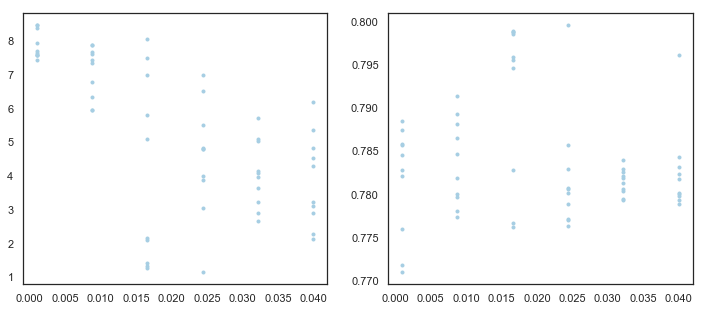

In [37]:
# Color schemes
colors = np.array([[166,206,227],
                [31,120,180],
                [178,223,138],
                [51,160,44],
                [251,154,153]]) / 255

# Load subject fit data
data = scipy.io.loadmat('PlotTools/IK_subject_fit_020519_thres0_7_constant_stage0_750ms_optimized3.mat')
combi_arr = data['combi_arr']

plt.figure(figsize=(12, 5))
# K plotting
plt.subplot(121)
#plt.plot(combi_arr2[:,0], combi_arr[:,2], 'rx')

for i in range(1):
    plt.plot(sigma_lst, Kresults[i], '.', color=colors[i])

# I plotting
plt.subplot(122)

#plt.plot(combi_arr2[:,0], combi_arr[:,1], 'rx')
for i in range(1):
    plt.plot(sigma_lst, Iresults[i], '.', color=colors[i])

In [56]:
combi_arr2 = combi_arr[:]
combi_arr2[0,:] = [0.00818, 0.778, 5.584]
combi_arr2[3,:] = [0.00636, 0.780, 6.077]
combi_arr2[5,:] = [0.00758, 0.780, 6.065]
combi_arr2[9,:] = [0.00742, 0.778, 5.717]

In [57]:
combi_arr2

array([[0.00818   , 0.778     , 5.584     ],
       [0.01984848, 0.77827926, 1.86711584],
       [0.01949495, 0.78006121, 2.39174214],
       [0.00636   , 0.78      , 6.077     ],
       [0.01737374, 0.77928775, 2.01344899],
       [0.00758   , 0.78      , 6.065     ],
       [0.01737374, 0.77963514, 1.41400684],
       [0.02126263, 0.77894898, 1.72886976],
       [0.02691919, 0.77608382, 1.6976787 ],
       [0.00742   , 0.778     , 5.717     ],
       [0.0219697 , 0.77914476, 2.41438744]])

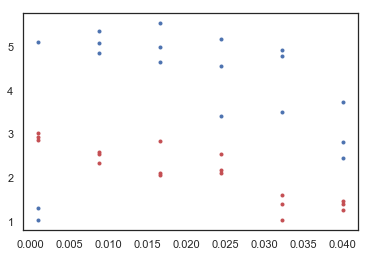

In [9]:
plt.plot(sigma_lst, Kresults[0], 'b.')
plt.plot(sigma_lst, Kresults[-1], 'r.')
#plt.plot(sigma_lst, Kresults[2], 'g.')
#plt.plot(sigma_lst, Kresults[-1], 'r.')

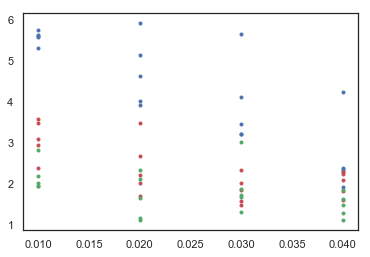

In [17]:
plt.plot(sigma_lst, Kresults[0], 'b.')
plt.plot(sigma_lst, Kresults[1], 'r.')
plt.plot(sigma_lst, Kresults[2], 'g.')
#plt.plot(sigma_lst, Kresults[-1], 'r.')

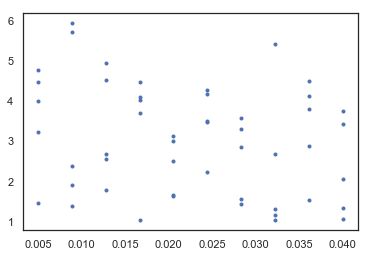

In [17]:
plt.plot(sigma_lst, KLST, 'b.')

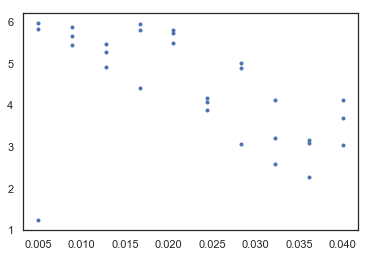

In [25]:
plt.plot(sigma_lst, KLST, 'b.')

In [ ]:
import time

### Doing random sampling for (I,K)

# Initiate the trial with a fixed current, trial duration is randomized in [600, 1000]
durations = np.linspace(600, 1000, 5)

sigma_lst = np.linspace(0.005, 0.04, 10)

nsamples = 100
nstages = 10

maxiter = 3
ILST = np.zeros((len(sigma_lst), maxiter))
KLST = np.zeros((len(sigma_lst), maxiter))

#Klst = np.linspace(0.5, 3.5, nsamples)

#bar = Bar('Processing', max=1000)
#bar.start()

start = time.time()

# Do simulation several times to obtain error bars
for id_s, sigma in enumerate(sigma_lst):
    print('*** sigma = ', sigma, ' ***')
    for niter in range(maxiter):
        print('    Running iteration #', niter)
        # For each iteration, re-pick list of I and K
        Klst = np.random.uniform(low=1, high=6, size=nsamples)
        initIlst = np.random.uniform(low=0.77, high=0.79, size=nsamples)
    
        mse_lst = np.zeros(nsamples)
        for i in range(nsamples):
            I = initIlst[i]
            K = Klst[i]
            mse_total = 0
            #print('        Doing time I = %f. K = %f' % (I, K))
            for k, dur in enumerate(durations):
                #print('        Doing time #%d = %f. I = %f. K = %f\n' % (k, time, I, K))

                ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=100, nstages=nstages, 
                                                                       duration=dur, sigma=sigma, K=K, initI=I)

                Ylst2 = np.array(ylst2)
                times = get_times_lst_from_y(np.array(Ylst2))
                times = times[(times > 0) & (times != np.inf)]

                mse_total += np.sum((times * 10 - dur)**2)

            mse_lst[i] = np.sqrt(np.mean(mse_total))
            #print('I = ', I, 'K = ', K, 'Total MSE = ', np.sqrt(np.mean(mse_total)))
            #bar.next()
        # Determine the arg-min of the list
        argmin = np.argsort(mse_lst)
        Kmin = Klst[argmin[0]]
        Imin = initIlst[argmin[0]]
        KLST[id_s][niter] = Kmin
        ILST[id_s][niter] = Imin
        print('        Kmin = ', Kmin, ', Imin =', Imin)

end = time.time()
print('Time taken = ', end - start)
# Save simulation results
#scipy.io.savemat('PlotTools/IK_optimization_data_I_0_78_1000trials.mat', {'initIlst': initIlst, 'Klst': Klst, 'KLST': KLST, 
#                                                  'ILST': ILST, 'sigma_lst': sigma_lst, 'PARAMS': PARAMS_DICT})
        
#bar.finish()
    
#plt.plot(initIlst, mse_lst)

*** sigma =  0.005  ***
    Running iteration # 0
        Kmin =  2.9756737834911386 , Imin = 0.7805323734141542
    Running iteration # 1
        Kmin =  3.8889902946802253 , Imin = 0.7821754462710986
    Running iteration # 2
        Kmin =  2.6181556944540483 , Imin = 0.7802945176936206
*** sigma =  0.008888888888888889  ***
    Running iteration # 0
        Kmin =  3.238908181153839 , Imin = 0.776205010753333
    Running iteration # 1
        Kmin =  3.5661133375027365 , Imin = 0.7866042658421407
    Running iteration # 2
        Kmin =  2.297364326199939 , Imin = 0.7768444786233386
*** sigma =  0.012777777777777779  ***
    Running iteration # 0
        Kmin =  2.4533558418962733 , Imin = 0.7811517579197104
    Running iteration # 1
        Kmin =  3.301470144112287 , Imin = 0.7789895258723817
    Running iteration # 2
        Kmin =  2.4762335547942667 , Imin = 0.7785702667443206
*** sigma =  0.016666666666666666  ***
    Running iteration # 0
        Kmin =  2.419460427301033 , 

Plotting the result of the simulation of optimized $(I, K)$ together with the fitted values.

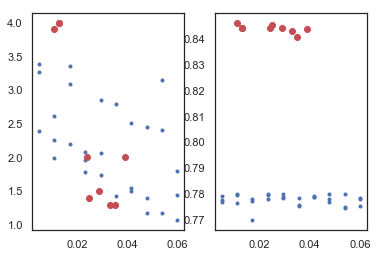

In [23]:
# Behavioral results
#sigma_behavior = [0.019, 0.019, 0.008, 0.02, 0.009, 0.01, 0.017, 0.0245, 0.026];
#I_behavior = [0.780, 0.779, 0.783, 0.780, 0.783, 0.782, 0.7805, 0.7792, 0.7773];
#K_behavior = [1.0, 1.0, 2.7, 1.0, 3.3, 2.7, 0.8, 0.8, 0.85];

# Params fit with threshold = 0.7
#sigma_behavior = [0.009, 0.018, 0.023, 0.007, 0.021, 0.009, 0.020, 0.025, 0.027];
#I_behavior = [0.781, 0.780, 0.780, 0.782, 0.781, 0.782, 0.781, 0.779, 0.777];
#K_behavior = [2.55, 1.10, 1.28, 2.76, 1.65, 2.89, 0.78, 0.67, 0.75];


# Params fit with threshold = 0.6
#sigma_behavior = [0.015, 0.026, 0.032, 0.012, 0.030, 0.013, 0.025, 0.035, 0.036];
#I_behavior = [0.848, 0.845, 0.844, 0.849, 0.845, 0.847, 0.845, 0.844, 0.841];
#K_behavior = [2.6, 1.0, 1.0, 2.7, 0.9, 2.7, 0.7, 0.7, 0.7];

# Fit with new model (with initial stage constant time)
sigma_behavior = [0.013, 0.024, 0.039, 0.011, 0.029, 0.013, 0.025, 0.033, 0.035];
I_behavior = [0.844, 0.844, 0.8435, 0.846, 0.844, 0.844, 0.845, 0.843, 0.8405];
K_behavior = [4.0, 2.0, 2.0, 3.9, 1.5, 4.0, 1.4, 1.3, 1.3];

plt.subplot(121)

for i, sigma in enumerate(sigma_lst):
    plt.plot(np.ones(maxiter) * sigma, KLST[i,:],'b.')
    
plt.plot(sigma_behavior, K_behavior, 'or')


plt.subplot('122')
plt.plot(sigma_behavior, I_behavior, 'or')

for i, sigma in enumerate(sigma_lst):
    plt.plot(np.ones(maxiter) * sigma, ILST[i,:],'b.')
    


In [200]:
scipy.io.savemat('PlotTools/IK_sim_relationship.mat', {'ILST': ILST, 'KLST': KLST,
                                            'sigma_lst': sigma_lst})

In [40]:
def find_min_indices(mat):
    '''Given a matrix, return the indices i, j such that mat[i][j] is the minimum entry'''
    idmin = np.argmin(mat)
    m, n = mat.shape
    
    return idmin // n, idmin % n

def find_min_IK(mat, Ivals, Kvals):
    '''Given the MSE matrix, find the I and K corresponding to the min MSE'''
    i, j = find_min_indices(mat)
    
    if i == 0 or i == len(Ivals) - 1:
        print('Warning: minimum at boundary for I')
    
    if j == 0 or j == len(Kvals) - 1:
        print('Warning: minimum at boundary for K')
    
    return Ivals[i], Kvals[j]
    



In [26]:
combi_arr

array([[0.00782828, 0.77830044, 4.74505009],
       [0.01984848, 0.77827926, 1.86711584],
       [0.01949495, 0.78006121, 2.39174214],
       [0.00712121, 0.7790352 , 4.8065633 ],
       [0.01737374, 0.77928775, 2.01344899],
       [0.00747475, 0.77981176, 4.90009457],
       [0.01737374, 0.77963514, 1.41400684],
       [0.02126263, 0.77894898, 1.72886976],
       [0.02691919, 0.77608382, 1.6976787 ],
       [0.00959596, 0.77895049, 4.96373417],
       [0.0219697 , 0.77914476, 2.41438744]])

Doing time # 0 = [600]
Doing time # 1 = [700]
Doing time # 2 = [800]
Doing time # 3 = [900]
Doing time # 4 = [1000]
Doing time # 0 = [600]
Doing time # 1 = [700]
Doing time # 2 = [800]
Doing time # 3 = [900]
Doing time # 4 = [1000]
RSG results:
Observed mean STD =  60.067726665412124
Simulated mean STD =  56.5466439521684
RSSG results:
Observed mean STD =  62.409422380986214
Simulated mean STD =  60.33757253781447


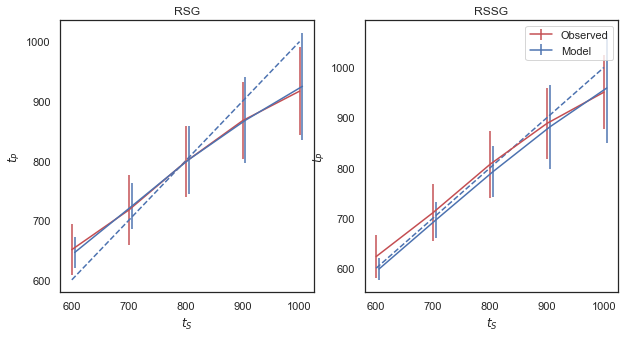

In [31]:
# Load data for subject GB (RSG/RSSG, Seth provided)
subject_file = all_subject_files[0]#'SWE_EKF_ObsAct0_20171105.mat'

sigma_val = 0.00782828
I_val = 0.77830044
K_val = 6


subject_data = scipy.io.loadmat(subject_file)
B = subject_data['B']
ts_vec = subject_data['ts_vec']
ta = subject_data['ta']
tss = subject_data['tss']
mtp_in = subject_data['mtp_in']
stdtp_in = subject_data['stdtp_in']

b = np.mean(B[:,0])

# Initiate the trial with a fixed current, trial duration is randomized in [400, 600]
durations = tss

prod_time_lst = []
prod_var_lst = []
prod_time_lst2 = []
prod_var_lst2 = []

#1,2,Go simulation
for i, time in enumerate(durations):
    print('Doing time #', i, '=', time)
    
    ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=1000, nstages=3, duration=time, 
                                                           sigma=sigma_val, K=K_val, initI=I_val)

    Ylst2 = np.array(ylst2)
    times = get_times_lst_from_y(np.array(Ylst2))
    times = times[(times > 0) & (times != np.inf)]
    #print('Mean level at decision time is ', np.mean(Ylst2[60,:]))
    #print('Mean decision time is ', np.mean(times))
    prod_time_lst.append(np.mean(times))
    prod_var_lst.append(np.std(times))

#1,2,3,Go simulation
for i, time in enumerate(durations):
    print('Doing time #', i, '=', time)
    
    ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=1000, nstages=4, duration=time, 
                                                           sigma=sigma_val, K=K_val, initI=I_val)

    Ylst2 = np.array(ylst2)
    times = get_times_lst_from_y(np.array(Ylst2))
    times = times[(times > 0) & (times != np.inf)]
    #print('Mean level at decision time is ', np.mean(Ylst2[60,:]))
    #print('Mean decision time is ', np.mean(times))
    prod_time_lst2.append(np.mean(times))
    prod_var_lst2.append(np.std(times))
    
# Plot the result, error bars represent standard deviation
plt.figure(figsize=(10, 5))
plt.subplot('121')
plt.errorbar(tss, mtp_in[:,0], stdtp_in[:,0], color='r', label='Observed')
#plt.errorbar(tss, mtp_in[:,1], stdtp_in[:,1], color='g')

# Plot the result, error bars represent standard deviation
plt.plot(durations, durations, '--')
plt.errorbar(durations + 5, np.array(prod_time_lst) * 10, np.array(prod_var_lst) * 10, color='b', label='Model')
plt.xlabel('$t_S$')
plt.ylabel('$t_P$')
plt.title('RSG')

plt.subplot('122')
plt.errorbar(tss, mtp_in[:,1], stdtp_in[:,1], color='r', label='Observed')
#plt.errorbar(tss, mtp_in[:,1], stdtp_in[:,1], color='g')

# Plot the result, error bars represent standard deviation
plt.plot(durations, durations, '--')
plt.errorbar(durations + 5, np.array(prod_time_lst2) * 10, np.array(prod_var_lst2) * 10, color='b', label='Model')
plt.xlabel('$t_S$')
plt.ylabel('$t_P$')
plt.title('RSSG')
plt.legend()

print('RSG results:')
print('Observed mean STD = ', np.mean(stdtp_in[:,0]))
print('Simulated mean STD = ', np.mean(np.mean(prod_var_lst)* 10))

print('RSSG results:')
print('Observed mean STD = ', np.mean(stdtp_in[:,1]))
print('Simulated mean STD = ', np.mean(np.mean(prod_var_lst2)* 10))

## Behavior fitting protocol

The protocol has two parts: (1) Fitting $(I,K)$ and (2) Fitting $\sigma$. $(I, K)$ is fitted based on the mean of the distribution, while $\sigma$ is fitted based on the standard deviation.

### $(I,K)$ fitting

In [41]:
def do_IK_fitting(subject_file, sigmaval, nsamples=100, Klow=1, Khigh=3.5, Ilow=0.75, Ihigh=0.78,
                 print_every=10):
    '''Inputs:
    - subject_file: .mat file with the behavioral results of the subject
    - sigmaval: sigma value to be used
    - nsamples: number of random (I, K) combinations to sample
    - Klow, Khigh, Ilow, Ihigh: ranges of I and K for sampling
    
    Outputs:
    I, K: the optimal combination to minimize the mse between the mean simulated times
    and the mean behavioral times of the subject'''

    Klst = np.random.uniform(low=Klow, high=Khigh, size=nsamples)
    initIlst = np.random.uniform(low=Ilow, high=Ihigh, size=nsamples)

    # Load data for subject SWE(RSG/RSSG, Seth provided)
    swedata = scipy.io.loadmat(subject_file)
    B = swedata['B']
    ts_vec = swedata['ts_vec']
    ta = swedata['ta']
    tss = swedata['tss']
    mtp_in = swedata['mtp_in']
    stdtp_in = swedata['stdtp_in']

    target_time1 = mtp_in[:,0]
    target_time2 = mtp_in[:,1]

    b = np.mean(B[:,0])

    durations = tss
    errorlst = []

    for k in range(nsamples):
        Ival = initIlst[k]
        Kval = Klst[k]

        prod_time_lst, prod_var_lst, prod_time_lst2, prod_var_lst2 = [], [], [], []

        #1,2,Go simulation
        for i, dur in enumerate(durations):
            times = get_time_lst(ntrials=100, nstages=3, duration=dur, 
                             sigma=sigmaval, K=Kval, initI=Ival)
            prod_time_lst.append(np.mean(times))
            prod_var_lst.append(np.std(times))

        #1,2,3,Go simulation
        for i, dur in enumerate(durations):
            times = get_time_lst(ntrials=100, nstages=4, duration=dur, 
                             sigma=sigmaval, K=Kval, initI=Ival)
            prod_time_lst2.append(np.mean(times))
            prod_var_lst2.append(np.std(times))

        # Continue if there is a nan   
        error1 = (np.array(prod_time_lst) * 10 - target_time1) ** 2
        error2 = (np.array(prod_time_lst2) * 10 - target_time2) ** 2
        if np.sum(np.isnan(error1)) + np.sum(np.isnan(error2)) > 0:
            error = np.inf
            print('nan encountered')
        else:
        # Error function to minimize
            error = np.sum((np.array(prod_time_lst) * 10 - target_time1) ** 2) 
                    #np.sum((np.array(prod_time_lst2) * 10 - target_time2) ** 2)
        errorlst.append(error)

        if k % print_every == 0: # Print every 10 lines
            print('    I = %f, K = %f, error = %f' %(Ival, Kval, error))
    
    # Find the optimal (I, K)
    idx = np.argmin(errorlst)
    print('Optimal (I, K) = ', initIlst[idx], Klst[idx])
    return initIlst[idx], Klst[idx]

In [42]:
def do_sigma_fitting(subject_file, Ival, Kval, nsamples=100, low=0.001, high=0.05, print_every=10):
    '''Inputs:
    - subject_file: .mat file with the behavioral results of the subject
    - Ival, Kval: I and K values to be used
    - nsamples: number of random (I, K) combinations to sample
    - Klow, Khigh, Ilow, Ihigh: ranges of I and K for sampling
    
    Outputs:
    sigma: the optimal sigma to minimize the mse between the std simulated times
    and the std behavioral times of the subject'''

    sigmalst = np.linspace(low, high, nsamples)

    # Load data for subject SWE(RSG/RSSG, Seth provided)
    swedata = scipy.io.loadmat(subject_file)
    B = swedata['B']
    ts_vec = swedata['ts_vec']
    ta = swedata['ta']
    tss = swedata['tss']
    mtp_in = swedata['mtp_in']
    stdtp_in = swedata['stdtp_in']

    target_std1 = stdtp_in[:,0]
    target_std2 = stdtp_in[:,1]

    b = np.mean(B[:,0])

    durations = tss
    errorlst = []

    for k in range(nsamples):
        sigmaval = sigmalst[k]
        prod_time_lst, prod_var_lst, prod_time_lst2, prod_var_lst2 = [], [], [], []

        #1,2,Go simulation
        for i, dur in enumerate(durations):
            times = get_time_lst(ntrials=100, nstages=3, duration=dur, 
                             sigma=sigmaval, K=Kval, initI=Ival)
            prod_time_lst.append(np.mean(times))
            prod_var_lst.append(np.std(times))

        #1,2,3,Go simulation
        for i, dur in enumerate(durations):
            times = get_time_lst(ntrials=100, nstages=4, duration=dur, 
                             sigma=sigmaval, K=Kval, initI=Ival)
            prod_time_lst2.append(np.mean(times))
            prod_var_lst2.append(np.std(times))
            
        # Continue if there is a nan   
        error1 = (np.array(prod_var_lst) * 10 - target_std1) ** 2
        error2 = (np.array(prod_var_lst2) * 10 - target_std2) ** 2
        if np.sum(np.isnan(error1)) + np.sum(np.isnan(error2)) > 0:
            error = np.inf
            print('nan encountered')
        else:
            # Error function to minimize
            error = np.sum((np.array(prod_var_lst) * 10 - target_std1) ** 2) 
                    #np.sum((np.array(prod_var_lst2) * 10 - target_std2) ** 2)
        
        errorlst.append(error)

        if k % print_every == 0: # Print every 10 lines
            print('    sigma = %f, error = %f' %(sigmaval, error))
    
    # Find the optimal (I, K)
    idx = np.argmin(errorlst)
    print('Optimal sigma = ', sigmalst[idx])
    return sigmalst[idx]

In [68]:
Ival = 0.788803541303048 
Kval = 1.3483052257635142

sigmaval = 0.005
prod_time_lst, prod_var_lst, prod_time_lst2, prod_var_lst2 = [], [], [], []

target_std1 = stdtp_in[:,0]
target_std2 = stdtp_in[:,1]

#1,2,Go simulation
for i, dur in enumerate(durations):
    times = get_time_lst(ntrials=100, nstages=3, duration=dur, 
                     sigma=sigmaval, K=Kval, initI=Ival)
    print(times)
    print(np.mean(times))
    prod_time_lst.append(np.mean(times))
    prod_var_lst.append(np.std(times))

#1,2,3,Go simulation
for i, dur in enumerate(durations):
    times = get_time_lst(ntrials=100, nstages=4, duration=dur, 
                     sigma=sigmaval, K=Kval, initI=Ival)
    prod_time_lst2.append(np.mean(times))
    prod_var_lst2.append(np.std(times))

# Eliminate nan's    
error1 = (np.array(prod_va
                   r_lst) * 10 - target_std1) ** 2
error2 = (np.array(prod_var_lst2) * 10 - target_std2) ** 2
if np.sum(np.isnan(error1)) + np.sum(np.isnan(error2)) > 0:
    continue

# Error function to minimize
error = np.sum((np.array(prod_var_lst) * 10 - target_std1) ** 2) + \
        np.sum((np.array(prod_var_lst2) * 10 - target_std2) ** 2)

[117. 118. 119.]
118.0
[138. 128.]
133.0
[]
nan
[]
nan
[]
nan


C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [43]:
def subject_fitting(subject_file, sigma_init=0.02, nsamples=100, nsamples2=100, Klow=1, Khigh=3.5, Ilow=0.75, Ihigh=0.78, 
                    sigmalow=0.005, sigmahigh=0.04, print_every=10, niter=5):
    '''Optimize for the given subject file,
    Returns the fitted combination (sigma, I, K)'''
    sigmaval = sigma_init
    for i in range(niter):
        Ival, Kval = do_IK_fitting(subject_file, sigmaval=sigmaval, nsamples=nsamples, 
                                   Klow=Klow, Khigh=Khigh, Ilow=Ilow, Ihigh=Ihigh, print_every=print_every)
        sigmaval = do_sigma_fitting(subject_file, Ival=Ival, Kval=Kval, nsamples=nsamples2, 
                                    low=sigmalow, high=sigmahigh, print_every=print_every)
    return sigmaval, Ival, Kval
    
    

In [44]:
all_subject_files = ['SWE_EKF_ObsAct0_20171105.mat', 'CV_EKF_ObsAct0_20171105.mat',
                    'GB_EKF_ObsAct0_20171105.mat', 'LB_EKF_ObsAct0_20171105.mat',
                    'PG_EKF_ObsAct0_20171105.mat', 'SM_EKF_ObsAct0_20171105.mat',
                    'TA_EKF_ObsAct0_20171105.mat', 'VD_EKF_ObsAct0_20171105.mat',
                    'VR_EKF_ObsAct0_20171105.mat',
                    'SWE_EKF_ObsAct0_20171125.mat', 'GB_EKF_ObsAct0_20171125.mat']

In [40]:
combi_arr

array([[0.00782828, 0.77830044, 4.74505009],
       [0.01984848, 0.77827926, 1.86711584],
       [0.01949495, 0.78006121, 2.39174214],
       [0.00712121, 0.7790352 , 4.8065633 ],
       [0.01737374, 0.77928775, 2.01344899],
       [0.00747475, 0.77981176, 4.90009457],
       [0.01737374, 0.77963514, 1.41400684],
       [0.02126263, 0.77894898, 1.72886976],
       [0.02691919, 0.77608382, 1.6976787 ],
       [0.00959596, 0.77895049, 4.96373417],
       [0.0219697 , 0.77914476, 2.41438744]])

In [36]:
combi = subject_fitting(all_subject_files[0], nsamples=1000, nsamples2=100, Klow=4.0, Khigh=7.5, 
                            sigmalow=0.005, sigmahigh=0.02, Ilow=0.77, Ihigh=0.79, print_every=50)

    I = 0.782817, K = 4.986437, error = 8175.907008
    I = 0.783339, K = 7.254710, error = 9503.616711
    I = 0.772827, K = 7.431578, error = 10396.583041
    I = 0.774776, K = 4.847648, error = 37823.652493
    I = 0.789660, K = 6.800674, error = 9188.489655
    I = 0.781894, K = 5.937501, error = 5176.881420
    I = 0.774332, K = 6.964409, error = 19456.474638
    I = 0.788664, K = 6.530243, error = 11077.373977
    I = 0.770096, K = 5.035548, error = 71508.040652
    I = 0.775429, K = 7.134805, error = 9700.153047
    I = 0.788235, K = 5.096717, error = 45569.937958
    I = 0.771350, K = 5.747545, error = 47029.020858
    I = 0.774424, K = 5.077315, error = 34428.572202
    I = 0.774374, K = 5.185474, error = 31773.763748
    I = 0.771614, K = 7.249679, error = 10266.578711
    I = 0.771972, K = 5.982179, error = 43615.038995
    I = 0.775414, K = 6.412793, error = 12032.454990
    I = 0.772575, K = 4.444930, error = 57086.631077
    I = 0.786343, K = 5.742537, error = 16887.99758

In [41]:
combi = subject_fitting(all_subject_files[3], nsamples=1000, nsamples2=100, Klow=4.0, Khigh=7.5, 
                            sigmalow=0.005, sigmahigh=0.02, Ilow=0.77, Ihigh=0.79, print_every=50)

    I = 0.787566, K = 5.320910, error = 25353.338508
    I = 0.789086, K = 7.365057, error = 16923.025054
    I = 0.780501, K = 7.351038, error = 21897.083875
    I = 0.788876, K = 6.817603, error = 18785.545136
    I = 0.780733, K = 7.126390, error = 19341.553868
    I = 0.771642, K = 7.428776, error = 31860.657120
    I = 0.784125, K = 5.431661, error = 9776.307500
    I = 0.785498, K = 7.408567, error = 19474.770977
    I = 0.770259, K = 7.103029, error = 38337.827697
    I = 0.778858, K = 6.679775, error = 22282.975737
    I = 0.789063, K = 4.481737, error = 75793.684567
    I = 0.787417, K = 6.070668, error = 13720.779360
    I = 0.777365, K = 6.839863, error = 28837.740333
    I = 0.779708, K = 4.916896, error = 28900.398848
    I = 0.780794, K = 5.254060, error = 17974.574576
    I = 0.784369, K = 6.673983, error = 23645.277845
    I = 0.786569, K = 6.397273, error = 13212.319963
    I = 0.772951, K = 4.652385, error = 95292.407340
    I = 0.773292, K = 7.427104, error = 23565.8

In [42]:
combi = subject_fitting(all_subject_files[5], nsamples=1000, nsamples2=100, Klow=4.0, Khigh=7.5, 
                            sigmalow=0.005, sigmahigh=0.02, Ilow=0.77, Ihigh=0.79, print_every=50)

    I = 0.785824, K = 6.008874, error = 8430.104029
    I = 0.786160, K = 6.181563, error = 8267.567382
    I = 0.772423, K = 5.133115, error = 66335.818644
    I = 0.783789, K = 7.432367, error = 8192.154924
    I = 0.771203, K = 4.530957, error = 97610.391631
    I = 0.784446, K = 4.809731, error = 18258.640266
    I = 0.785003, K = 5.066436, error = 12698.818984
    I = 0.772045, K = 7.435483, error = 19027.278154
    I = 0.784848, K = 5.725206, error = 7863.262112
    I = 0.778008, K = 5.701657, error = 19936.029294
    I = 0.789452, K = 5.418728, error = 34091.518018
    I = 0.776774, K = 4.606827, error = 28230.049013
    I = 0.778946, K = 4.233680, error = 27245.573229
    I = 0.770446, K = 7.481863, error = 20256.641951
    I = 0.775399, K = 4.326029, error = 58366.071332
    I = 0.782769, K = 7.281511, error = 8456.894369
    I = 0.775909, K = 7.496562, error = 9232.657253
    I = 0.776153, K = 7.101695, error = 18088.728534
    I = 0.780776, K = 6.050703, error = 10038.018846

In [43]:
combi = subject_fitting(all_subject_files[9], nsamples=1000, nsamples2=100, Klow=4.0, Khigh=7.5, 
                            sigmalow=0.005, sigmahigh=0.02, Ilow=0.77, Ihigh=0.79, print_every=50)

    I = 0.773780, K = 5.579418, error = 31002.318504
    I = 0.781362, K = 6.958123, error = 11440.114010
    I = 0.770127, K = 5.803532, error = 43504.261096
    I = 0.782189, K = 7.312335, error = 13301.911100
    I = 0.784305, K = 5.884662, error = 8088.218909
    I = 0.781254, K = 4.400120, error = 10714.242663
    I = 0.785537, K = 5.206917, error = 28811.671173
    I = 0.784184, K = 6.460229, error = 7289.001866
    I = 0.777132, K = 7.286763, error = 9046.430971
    I = 0.787536, K = 6.810909, error = 10489.699841
    I = 0.773138, K = 4.374354, error = 68883.590136
    I = 0.773815, K = 4.487323, error = 55600.893318
    I = 0.776199, K = 4.480352, error = 28884.364250
    I = 0.787625, K = 6.446455, error = 15386.693035
    I = 0.784370, K = 4.841211, error = 25184.711586
    I = 0.772384, K = 5.443657, error = 48197.606259
    I = 0.776450, K = 6.434169, error = 16987.825603
    I = 0.778103, K = 5.296173, error = 8834.334040
    I = 0.774115, K = 6.203391, error = 21765.8059

In [45]:
#all_subject_files = ['SWE_EKF_ObsAct0_20171125.mat', 'GB_EKF_ObsAct0_20171125.mat']

combi_collection = []
for subject_file in all_subject_files:
    print(' ********* Doing subject file %s ************' % subject_file)
    combi = subject_fitting(subject_file, nsamples=1000, nsamples2=100, Klow=1.0, Khigh=5.0, 
                            Ilow=0.77, Ihigh=0.79, print_every=50)
    combi_collection.append(combi)

 ********* Doing subject file SWE_EKF_ObsAct0_20171105.mat ************
    I = 0.785097, K = 2.058248, error = 172344.160739
    I = 0.786615, K = 1.053122, error = 464248.975811
    I = 0.781264, K = 4.515806, error = 4007.351224
    I = 0.779999, K = 3.240268, error = 9068.556524
    I = 0.784738, K = 1.835152, error = 146506.699060
    I = 0.789842, K = 2.835702, error = 389061.461865
    I = 0.770464, K = 2.266803, error = 102109.511237
    I = 0.778342, K = 1.417779, error = 27981.371659
    I = 0.779584, K = 1.246927, error = 37971.426953
    I = 0.787438, K = 2.080638, error = 364776.683605
    I = 0.788765, K = 4.469858, error = 85591.062816
    I = 0.782770, K = 3.623843, error = 23528.803519
    I = 0.782603, K = 1.162158, error = 98554.488202
    I = 0.771786, K = 1.155958, error = 109304.421164
    I = 0.776530, K = 3.881940, error = 18012.539695
    I = 0.780566, K = 2.096421, error = 31764.207181
    I = 0.779048, K = 4.826121, error = 4104.533328
    I = 0.780020, K = 4

C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan encountered
    I = 0.771036, K = 4.200190, error = 45908.232588
    I = 0.785602, K = 2.199773, error = 586318.414786
    I = 0.772387, K = 4.629759, error = 27712.075565
    I = 0.783947, K = 2.137640, error = 255214.991134
    I = 0.777990, K = 3.783789, error = 5742.282668
    I = 0.786885, K = 3.443979, error = 444789.193533
Optimal (I, K) =  0.7784936288592175 4.952274520348716
    sigma = 0.005000, error = 3341.457298
    sigma = 0.022677, error = 9120.425402
Optimal sigma =  0.009595959595959597
    I = 0.776575, K = 1.938576, error = 24955.565375
    I = 0.780608, K = 3.222059, error = 22216.824000
    I = 0.771224, K = 2.527645, error = 76372.910802
    I = 0.786831, K = 1.575609, error = 1075068.033242
    I = 0.773125, K = 3.231604, error = 40811.001385
    I = 0.787218, K = 3.743108, error = 294951.786687
    I = 0.780473, K = 2.900429, error = 26747.706110
    I = 0.770600, K = 1.960717, error = 98431.998515
    I = 0.779387, K = 2.673437, error = 20658.361845
    I =

    I = 0.774561, K = 1.419257, error = 34436.299843
    I = 0.786472, K = 4.679732, error = 68766.516953
    I = 0.780159, K = 2.041066, error = 10179.552761
    I = 0.771895, K = 2.477627, error = 61077.276950
    I = 0.772578, K = 2.364571, error = 52285.445462
    I = 0.779381, K = 2.166220, error = 1466.345100
    I = 0.783781, K = 1.483478, error = 155774.219344
    I = 0.788272, K = 4.805586, error = 93243.951595
    I = 0.788481, K = 3.157017, error = 308732.072343
    I = 0.783848, K = 4.317606, error = 35468.900406
    I = 0.783254, K = 1.533319, error = 109372.785631
    I = 0.776772, K = 4.224042, error = 9849.928510
    I = 0.783589, K = 1.743756, error = 109751.328719
    I = 0.778541, K = 1.701694, error = 2830.695430
    I = 0.776284, K = 3.397103, error = 13157.643448
    I = 0.784414, K = 1.114608, error = 241544.945795
Optimal (I, K) =  0.7789004295874985 3.1473442108093557
    sigma = 0.005000, error = 15645.422987
    sigma = 0.022677, error = 1846.039604
Optimal s

    I = 0.788063, K = 2.861496, error = 177758.257295
    I = 0.775238, K = 2.755504, error = 17175.384332
Optimal (I, K) =  0.7800023678248136 2.79809865173646
    sigma = 0.005000, error = 13081.933615
    sigma = 0.022677, error = 6913.065837
Optimal sigma =  0.016313131313131314
 ********* Doing subject file LB_EKF_ObsAct0_20171105.mat ************
    I = 0.771366, K = 4.142507, error = 89150.620990
    I = 0.776361, K = 4.173826, error = 37873.670158
    I = 0.782443, K = 1.970939, error = 66326.700942
    I = 0.785691, K = 2.080932, error = 196409.867408
    I = 0.777729, K = 3.156766, error = 35439.804659
    I = 0.781761, K = 1.911854, error = 55450.859671
    I = 0.786884, K = 3.186201, error = 119252.977267
    I = 0.773127, K = 3.886285, error = 71395.922233
    I = 0.779942, K = 1.807802, error = 57607.237661
    I = 0.786211, K = 3.371258, error = 88672.932782
    I = 0.774483, K = 1.597468, error = 93730.366259
    I = 0.774923, K = 4.924567, error = 39546.783275
    I =

    I = 0.781869, K = 2.724613, error = 8855.979121
    I = 0.787140, K = 1.936441, error = 265704.929624
    I = 0.784638, K = 2.570849, error = 52761.920197
    I = 0.777450, K = 1.494033, error = 9943.418503
    I = 0.770623, K = 3.172164, error = 94704.402313
    I = 0.775405, K = 3.022259, error = 32347.401161
    I = 0.772654, K = 2.553983, error = 67343.664775
    I = 0.780133, K = 1.199734, error = 5333.956940
    I = 0.780416, K = 4.626325, error = 11925.615670
    I = 0.780971, K = 3.786531, error = 7648.369530
    I = 0.782313, K = 2.466478, error = 14793.841694
    I = 0.770480, K = 3.244134, error = 91451.673923
    I = 0.784396, K = 1.433447, error = 105791.841135
    I = 0.785131, K = 1.138518, error = 201122.994357
    I = 0.780648, K = 2.960229, error = 3520.259013
    I = 0.774801, K = 1.283943, error = 44852.226480
    I = 0.786922, K = 1.383466, error = 323655.203396
    I = 0.781862, K = 1.491287, error = 24822.683677
    I = 0.779807, K = 2.492083, error = 651.478

    I = 0.784451, K = 4.484973, error = 45907.390231
    I = 0.779363, K = 1.888409, error = 44679.415639
    I = 0.771176, K = 2.685029, error = 101184.562719
    I = 0.780143, K = 3.825984, error = 15706.114932
    I = 0.786398, K = 1.050084, error = 1304123.480868
    I = 0.785901, K = 4.515376, error = 88756.851001
    I = 0.789221, K = 1.455265, error = 1570426.648296
    I = 0.774385, K = 2.674465, error = 58040.740811
nan encountered
    I = 0.787300, K = 4.713138, error = 145483.223036
Optimal (I, K) =  0.7789723212307607 4.772629632309581
    sigma = 0.005000, error = 3198.285035
    sigma = 0.022677, error = 17810.966017
Optimal sigma =  0.011010101010101012
    I = 0.784832, K = 1.750338, error = 349415.556309
    I = 0.787996, K = 2.554532, error = 789643.515007
    I = 0.783174, K = 4.604024, error = 22875.378696
    I = 0.780622, K = 4.461743, error = 7199.167442
    I = 0.785832, K = 2.021462, error = 448689.606665
    I = 0.776216, K = 2.687330, error = 37297.832026
   

Optimal sigma =  0.02055555555555556
    I = 0.770365, K = 4.800659, error = 92608.458069
    I = 0.770703, K = 4.126836, error = 104564.391716
    I = 0.777141, K = 3.414987, error = 30893.225526
    I = 0.783471, K = 4.700823, error = 18280.322527
    I = 0.774590, K = 3.012429, error = 60399.576270
    I = 0.781860, K = 1.964083, error = 4893.704246
    I = 0.789040, K = 2.942176, error = 218734.040467
    I = 0.773213, K = 3.639086, error = 78984.619552
    I = 0.773807, K = 2.461132, error = 75885.984880
    I = 0.777720, K = 1.929692, error = 18904.059246
    I = 0.770290, K = 4.935070, error = 103490.624884
    I = 0.771454, K = 4.764469, error = 87038.805823
    I = 0.782476, K = 1.763697, error = 15155.692412
    I = 0.786469, K = 3.848327, error = 54993.147796
    I = 0.788741, K = 2.655509, error = 252592.781609
    I = 0.789937, K = 4.636772, error = 99530.346486
    I = 0.783403, K = 4.279319, error = 14513.759218
    I = 0.771938, K = 4.547083, error = 83234.878850
    I 

    I = 0.777131, K = 4.127938, error = 12309.076155
    I = 0.770853, K = 1.719290, error = 17169.234839
    I = 0.778764, K = 1.134979, error = 29769.611514
    I = 0.773074, K = 2.716268, error = 2718.520204
    I = 0.787866, K = 2.134568, error = 614689.600687
    I = 0.781565, K = 2.306079, error = 79788.914478
    I = 0.786952, K = 4.255491, error = 174379.565531
    I = 0.781952, K = 3.259527, error = 79738.243951
Optimal (I, K) =  0.7750132303733528 1.7990387611461816
    sigma = 0.005000, error = 21527.096569
    sigma = 0.022677, error = 1028.270584
Optimal sigma =  0.02833333333333334
    I = 0.773700, K = 2.060529, error = 5916.488069
    I = 0.777874, K = 4.794580, error = 11627.370292
    I = 0.787397, K = 3.179019, error = 191492.415922
    I = 0.788210, K = 1.216256, error = 499799.760564
    I = 0.774290, K = 3.347739, error = 2575.386995
    I = 0.786673, K = 2.640898, error = 233084.474840
    I = 0.777020, K = 1.336060, error = 3367.379343
    I = 0.785907, K = 4.40

    I = 0.779146, K = 4.262149, error = 3763.215085
    I = 0.786989, K = 4.237860, error = 180127.461521
    I = 0.781352, K = 2.681307, error = 51191.881426
    I = 0.782480, K = 2.926307, error = 72429.002111
    I = 0.787939, K = 1.182819, error = 1326266.320114
    I = 0.781680, K = 2.395679, error = 67145.115854
    I = 0.788383, K = 4.855843, error = 146533.047179
    I = 0.785343, K = 3.522588, error = 162315.487683
    I = 0.782152, K = 3.519139, error = 40575.719917
    I = 0.778517, K = 1.963510, error = 22371.647592
    I = 0.778600, K = 1.739179, error = 28077.750392
    I = 0.785672, K = 3.642161, error = 183451.226238
    I = 0.774853, K = 1.172381, error = 47477.131499
    I = 0.784245, K = 4.998096, error = 39012.615637
    I = 0.777031, K = 1.737673, error = 27870.492480
    I = 0.785251, K = 3.900514, error = 121718.665354
    I = 0.774333, K = 4.881276, error = 12492.410034
    I = 0.774233, K = 2.574988, error = 38515.183311
Optimal (I, K) =  0.7780330143518198 4.6

    I = 0.772128, K = 4.283505, error = 31605.897601
    I = 0.785061, K = 3.412778, error = 67983.791983
    I = 0.773479, K = 3.191190, error = 25741.380454
    I = 0.785740, K = 3.642382, error = 106249.470938
    I = 0.772372, K = 3.049875, error = 37553.080510
Optimal (I, K) =  0.778450041961061 3.078440718103339
    sigma = 0.005000, error = 15606.299529
    sigma = 0.022677, error = 1423.791976
Optimal sigma =  0.020909090909090912
    I = 0.787387, K = 3.670382, error = 140096.117733
    I = 0.771948, K = 3.628584, error = 36771.838255
    I = 0.774169, K = 3.730780, error = 22170.433564
    I = 0.772972, K = 3.320239, error = 36359.075428
    I = 0.783432, K = 3.771343, error = 28021.939185
    I = 0.776749, K = 2.531941, error = 5286.331921
    I = 0.781705, K = 1.443815, error = 48405.412968
    I = 0.772645, K = 2.326893, error = 43728.248141
    I = 0.785718, K = 4.134473, error = 58950.524904
    I = 0.772067, K = 2.888777, error = 48203.415279
    I = 0.780554, K = 2.480

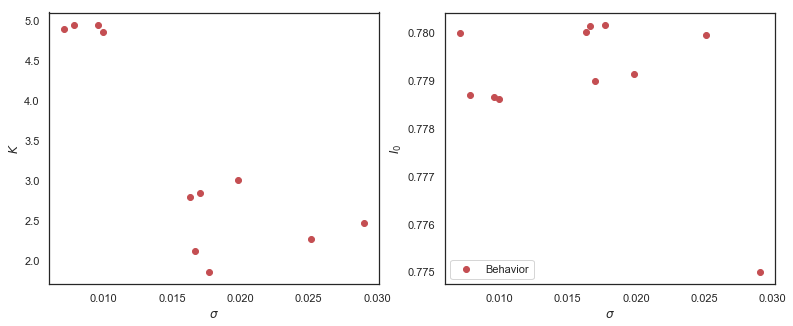

In [47]:
# Collate results
combi_arr = np.array(combi_collection)
sigmas = combi_arr[:,0]
Iarr = combi_arr[:,1]
Karr = combi_arr[:,2]

# Plot the results
plt.figure(figsize=(13,5))
plt.subplot(121)
# Simulation
#for i, sigma in enumerate(sigma_lst):
#    plt.plot(np.ones(maxiter) * sigma, KLST[i,:],'b.')
# Behavior
plt.plot(sigmas, Karr, 'or')

plt.xlabel(r'$\sigma$')
plt.ylabel(r'$K$')

plt.subplot('122')
# Simulation
#for i, sigma in enumerate(sigma_lst):
#    plt.plot(np.ones(maxiter) * sigma, ILST[i,:],'b.')
# Behavior
plt.plot(sigmas, Iarr, 'or', label='Behavior')

plt.xlabel(r'$\sigma$')
plt.ylabel(r'$I_0$')
plt.legend()

#plt.savefig('KI_relationship.pdf')

In [86]:
scipy.io.savemat('PlotTools/IK_subject_fit_020419_thres0_7_constant_stage0_750ms.mat', 
                 {'combi_arr': combi_arr, 'all_subject_files': all_subject_files})
scipy.io.savemat('PlotTools/IK_relationship_020419_constant_stage0_750ms.mat',
                {'ILST': ILST, 'KLST': KLST, 'sigma_lst': sigma_lst})

C:\Anaconda3\lib\site-packages\scipy\io\matlab\miobase.py:414: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  arr[empties] = ' '


## Plot model and subject BIAS, VAR, and RMSE

In [59]:
collated_bias_var = []

for i in range(len(all_subject_files)):
    print('Doing subject #%d of %d...' % (i + 1, len(all_subject_files)))
    # Load data for subject
    subject_file = all_subject_files[i]
    sigmaval = combi_arr2[i,0]
    Ival = combi_arr2[i,1]
    Kval = combi_arr2[i,2]

    swedata = scipy.io.loadmat(subject_file)
    B = swedata['B']
    ts_vec = swedata['ts_vec']
    ta = swedata['ta']
    tss = swedata['tss']
    mtp_in = swedata['mtp_in']
    stdtp_in = swedata['stdtp_in']

    target_time1 = mtp_in[:,0]
    target_time2 = mtp_in[:,1]

    b = np.mean(B[:,0])

    durations = tss
    errorlst = []

    prod_time_lst, prod_var_lst, prod_time_lst2, prod_var_lst2 = [], [], [], []

    #1,2,Go simulation
    for i, dur in enumerate(durations):
        times = get_time_lst(ntrials=100, nstages=3, duration=dur, 
                         sigma=sigmaval, K=Kval, initI=Ival)
        prod_time_lst.append(np.mean(times))
        prod_var_lst.append(np.std(times))

    #1,2,3,Go simulation
    for i, dur in enumerate(durations):
        times = get_time_lst(ntrials=100, nstages=4, duration=dur, 
                         sigma=sigmaval, K=Kval, initI=Ival)
        prod_time_lst2.append(np.mean(times))
        prod_var_lst2.append(np.std(times))

    # Bias
    bias_model1 = np.sum((np.array(prod_time_lst) * 10 - tss.T)**2) / len(tss)
    bias_subject1 = np.sum((target_time1 - tss.T)**2) / len(tss)
    bias_model2 = np.sum((np.array(prod_time_lst2) * 10 - tss.T)**2) / len(tss)
    bias_subject2 = np.sum((target_time2 - tss.T)**2) / len(tss)

    # Variance
    var_model1 = np.sum((np.array(prod_var_lst) * 10)**2) / len(tss)
    var_subject1 = np.sum(stdtp_in[:,0]**2) / len(tss)
    var_model2 = np.sum((np.array(prod_var_lst2) * 10)**2) / len(tss)
    var_subject2 = np.sum(stdtp_in[:,1]**2) / len(tss)
    
    # Collate
    collated_bias_var.append((bias_model1, bias_subject1, bias_model2, bias_subject2,
                             var_model1, var_subject1, var_model2, var_subject2))

collated_bias_var = np.sqrt(np.array(collated_bias_var))

Doing subject #1 of 11...
Doing subject #2 of 11...
Doing subject #3 of 11...
Doing subject #4 of 11...
Doing subject #5 of 11...
Doing subject #6 of 11...
Doing subject #7 of 11...
Doing subject #8 of 11...
Doing subject #9 of 11...
Doing subject #10 of 11...
Doing subject #11 of 11...


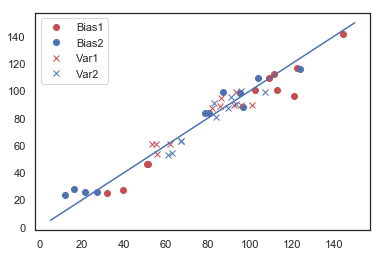

In [61]:
# Plot bias and variance
plt.plot(collated_bias_var[:,0], collated_bias_var[:,1], 'ro', label='Bias1')
plt.plot(collated_bias_var[:,2], collated_bias_var[:,3], 'bo', label='Bias2')
plt.plot(collated_bias_var[:,4], collated_bias_var[:,5], 'rx', label='Var1')
plt.plot(collated_bias_var[:,6], collated_bias_var[:,7], 'bx', label='Var2')
plt.plot([5,150], [5, 150])
plt.legend()

In [64]:
# Save collated bias and variance
suffix = '020519_thres0_7_constant_stage0_750ms_optimized3_Krange1to7.mat'
scipy.io.savemat('PlotTools/IK_subject_fit_' + suffix, 
                 {'combi_arr': combi_arr2, 'all_subject_files': all_subject_files})
scipy.io.savemat('PlotTools/IK_relationship_multi_' + suffix,
                {'Iresults': Iresults, 'Kresults': Kresults, 'sigma_lst': sigma_lst})
scipy.io.savemat('PlotTools/biasvar_' + suffix, 
                 {'collated_bias_var': collated_bias_var, 'all_subject_files': all_subject_files})

C:\Anaconda3\lib\site-packages\scipy\io\matlab\miobase.py:414: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  arr[empties] = ' '


In [62]:
Iresults

[array([[0.78809019, 0.78884011, 0.78673917, 0.78835308, 0.78998716,
         0.7872017 , 0.78831219, 0.78965924, 0.78987637, 0.78751713],
        [0.77876566, 0.7780018 , 0.78034834, 0.78100918, 0.77925654,
         0.7803639 , 0.77809483, 0.77711177, 0.77947069, 0.78027868],
        [0.78002692, 0.7770923 , 0.7785422 , 0.77912482, 0.779219  ,
         0.78007803, 0.77678187, 0.77891956, 0.78097363, 0.78085924],
        [0.78174379, 0.77876805, 0.77882841, 0.77921543, 0.77939682,
         0.77878389, 0.78279536, 0.78107547, 0.78052628, 0.78093314],
        [0.77940451, 0.78033891, 0.78013772, 0.78238905, 0.77953525,
         0.78305766, 0.78372731, 0.77986596, 0.77773973, 0.78352933],
        [0.78052154, 0.78090044, 0.78038872, 0.78520526, 0.78139775,
         0.77789012, 0.77905976, 0.77982284, 0.78101287, 0.78034774]]),
 array([[0.78140293, 0.78440769, 0.7814341 , 0.78167253, 0.78306761,
         0.78194615, 0.78165691, 0.78080198, 0.78094916, 0.78092764],
        [0.77704907, 0.77

In [67]:
suffix = '020719_thres0_7_constant_stage0_750ms_optimized3_Krange1to7B.mat'

scipy.io.savemat('PlotTools/IK_relationship_multi_' + suffix,
                {'Iresults': Iresults, 'Kresults': Kresults, 'sigma_lst': sigma_lst,
                'nstages': np.arange(3, 14), 'PARAMS': PARAMS_DICT})
